<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Defining-and-implementing-a-cost-function" data-toc-modified-id="Defining-and-implementing-a-cost-function-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Defining and implementing a cost function</a></span></li><li><span><a href="#Solving-for-optimal-estimate" data-toc-modified-id="Solving-for-optimal-estimate-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Solving for optimal estimate</a></span></li><li><span><a href="#Look-up-table" data-toc-modified-id="Look-up-table-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Look up table</a></span><ul class="toc-item"><li><span><a href="#A-faster-LUT" data-toc-modified-id="A-faster-LUT-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>A faster LUT</a></span></li></ul></li><li><span><a href="#Exercise" data-toc-modified-id="Exercise-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exercise</a></span></li><li><span><a href="#Using-a-minimisation-routine" data-toc-modified-id="Using-a-minimisation-routine-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Using a minimisation routine</a></span></li><li><span><a href="#Exercise" data-toc-modified-id="Exercise-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Exercise</a></span></li></ul></div>

In [ ]:
from geog0111.geog_data import procure_dataset

_ = procure_dataset("lai_data")

In [37]:
# Some imports that might be useful...
# Put them at the top so they're easy to find
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
from pathlib import Path
import gdal
from datetime import datetime, timedelta

def get_sfc_qc(qa_data, mask57 = 0b11100000):
    sfc_qa = np.right_shift(np.bitwise_and(qa_data, mask57), 5)
    return sfc_qa

def get_scaling(sfc_qa, golden_ratio=0.61803398875):
    weight = np.zeros_like(sfc_qa, dtype=np.float)
    for qa_val in [0, 1, 2, 3]:
        weight[sfc_qa == qa_val] = np.power(golden_ratio, float(qa_val))
    return weight


def find_mcdfiles(year, doy, tiles, folder):
    data_folder = Path(folder)
    # Find all MCD files
    mcd_files = []
    for tile in tiles:
        sel_files = data_folder.glob(
            f"MCD15*.A{year:d}{doy:03d}.{tile:s}.*hdf")
        for fich in sel_files:
            mcd_files.append(fich)
    return mcd_files


def create_gdal_friendly_names(filenames, layer):

    # Create GDAL friendly-names...
    gdal_filenames = []
    for file_name in filenames:
        fname = f'HDF4_EOS:EOS_GRID:'+\
                    f'"{file_name.as_posix()}":'+\
                    f'MOD_Grid_MCD15A3H:{layer:s}'

        gdal_filenames.append(fname)
    return gdal_filenames



def mosaic_and_clip(tiles,
                    doy,
                    year,
                    folder="data/",
                    layer="Lai_500m",
                    shpfile="data/TM_WORLD_BORDERS-0.3.shp",
                    country_code="LU",
                    frmat="MEM"):
    """
    #TODO docstring missing!!!!
    """

    folder_path = Path(folder)
    # Find all files to mosaic together
    hdf_files = find_mcdfiles(year, doy, tiles, folder)

    # Create GDAL friendly-names...
    gdal_filenames = create_gdal_friendly_names(hdf_files, layer)
    if frmat == "MEM":
        g = gdal.Warp(
            "",
            gdal_filenames,
            format="MEM",
            dstNodata=255,
            cutlineDSName=shpfile,
            cutlineWhere=f"FIPS='{country_code:s}'",
            cropToCutline=True)
        if g:
            data = g.ReadAsArray()
            return data
        else:
            raise RuntimeError(f'failed to warp {str(gdal_filenames)}')
    elif frmat == "GTiff":
        geotiff_fnamex = f"{layer:s}_{year:d}_{doy:03d}_{country_code:s}.tif"
        geotiff_fname  = folder_path/geotiff_fnamex
        g = gdal.Warp(
            geotiff_fname.as_posix(),
            gdal_filenames,
            format=frmat,
            dstNodata=255,
            cutlineDSName=shpfile,
            cutlineWhere=f"FIPS='{country_code:s}'",
            cropToCutline=True)
        if g:
            del g
            return geotiff_fname.as_posix()
        else:
            raise RuntimeError(f'failed to warp {str(gdal_filenames)}')
    else:
        raise ValueError("Only MEM or GTiff formats supported!")
        
        
def process_single_date(tiles,
                    doy,
                    year,
                    folder="data/",
                    shpfile="data/TM_WORLD_BORDERS-0.3.shp",
                    country_code="LU",
                    frmat="MEM"):
    
    lai_data = mosaic_and_clip(tiles,
                    doy,
                    year,
                    folder=folder,
                    layer="Lai_500m",
                    shpfile=shpfile,
                    country_code=country_code,
                    frmat="MEM")*0.1
    # Note the scaling!
    
    qa_data = mosaic_and_clip(tiles,
                    doy,
                    year,
                    folder=folder,
                    layer="FparLai_QC",
                    shpfile=shpfile,
                    country_code=country_code,
                    frmat="MEM")
    sfc_qa = get_sfc_qc(qa_data)
    
    weights = get_scaling(sfc_qa)
    return lai_data, weights

from datetime import datetime, timedelta


def process_timeseries(year,
                       tiles,
                       folder="data/",
                       shpfile='data/TM_WORLD_BORDERS-0.3.shp',
                       country_code='LU',
                       verbose=True):

    today = datetime(year, 1, 1)
    dates = []
    for i in range(92):
        if (i%10 == 0) and verbose:
            print(f"Doing {str(today):s}")
        if today.year != year:
            break
        doy = int(today.strftime("%j"))

        this_lai, this_weight = process_single_date(
            tiles,
            doy,
            year,
            folder=folder,
            shpfile=shpfile,
            country_code=country_code,
            frmat="MEM")
        if doy == 1:
            # First day, create outputs!
            ny, nx = this_lai.shape
            lai_array = np.zeros((ny, nx, 92))
            weights_array = np.zeros((ny, nx, 92))
        lai_array[:, :, i] = this_lai
        weights_array[:, :, i] = this_weight
        dates.append(today)
        today = today + timedelta(days=4)
    return dates, lai_array, weights_array

In [38]:
g = gdal.Open('data/MCD15A3H.A2017001.h17v03.006.2017014005341.hdf')
for s in g.GetSubDatasets():
    print(s)

('HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2017001.h17v03.006.2017014005341.hdf":MOD_Grid_MCD15A3H:Fpar_500m', '[2400x2400] Fpar_500m MOD_Grid_MCD15A3H (8-bit unsigned integer)')
('HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2017001.h17v03.006.2017014005341.hdf":MOD_Grid_MCD15A3H:Lai_500m', '[2400x2400] Lai_500m MOD_Grid_MCD15A3H (8-bit unsigned integer)')
('HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2017001.h17v03.006.2017014005341.hdf":MOD_Grid_MCD15A3H:FparLai_QC', '[2400x2400] FparLai_QC MOD_Grid_MCD15A3H (8-bit unsigned integer)')
('HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2017001.h17v03.006.2017014005341.hdf":MOD_Grid_MCD15A3H:FparExtra_QC', '[2400x2400] FparExtra_QC MOD_Grid_MCD15A3H (8-bit unsigned integer)')
('HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2017001.h17v03.006.2017014005341.hdf":MOD_Grid_MCD15A3H:FparStdDev_500m', '[2400x2400] FparStdDev_500m MOD_Grid_MCD15A3H (8-bit unsigned integer)')
('HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2017001.h17v03.006.2017014005341.hdf":MOD_Grid_MCD15A3H:LaiStdDev_500m', '[2400x2400] 

In [39]:
tiles = []
for h in [17, 18]:
    for v in [3, 4]:
        tiles.append(f"h{h:02d}v{v:02d}")
        
dates, lai_array, weights_array = process_timeseries(2017,tiles)

Doing 2017-01-01 00:00:00
Doing 2017-02-10 00:00:00
Doing 2017-03-22 00:00:00
Doing 2017-05-01 00:00:00
Doing 2017-06-10 00:00:00
Doing 2017-07-20 00:00:00
Doing 2017-08-29 00:00:00
Doing 2017-10-08 00:00:00
Doing 2017-11-17 00:00:00
Doing 2017-12-27 00:00:00


In [43]:
print(lai_array.shape,np.array(dates).shape)

(176, 123, 92) (92,)


In [ ]:
python setup.py install --user

go to

http://apps.ecmwf.int/datasets/licences/general/

In [5]:
from ecmwfapi import ECMWFDataServer
from pathlib import Path

ofile = 'data/europe_data_2016_2017.nc'
if not Path(ofile).exists():
    server = ECMWFDataServer()
    print('requesting data ... may take some time')
    server.retrieve({
        "class": "ei",
        "dataset": "interim",
        "date": "2016-01-01/to/2017-12-31", # Time period
        "expver": "1",
        "levtype": "sfc",
        "param": "2t",           # Parameters. Here we use 2m Temperature (2t)  See the ECMWF parameter database, at http://apps.ecmwf.int/codes/grib/param-db
        "stream": "oper",
        "type": "an",
        "time": "12",
        "step": "0",
        "area": "75/-20/10/60",    # Subset or clip to an area, here to Europe. Specify as North/West/South/East in Geographic lat/long degrees. Southern latitudes and Western longitudes must be given as negative numbers.
        "grid": "0.25/0.25",        # Regrid from the default grid to a regular lat/lon with specified resolution. The first number is east-west resolution (longitude) and the second is north-south (latitude).
        "format": "netcdf",         # Convert the output file from the default GRIB format to NetCDF format. Requires "grid" to be set to a regular lat/lon grid.
        "target": f"{ofile}",    # The output file name. Set this to whatever you like.
    })
else: print(f'{ofile} exists')

data/europe_data_2016_2017.nc exists


In [34]:
import requests
import shutil
from pathlib import Path

force = True
# zip file
zipfile = 'TM_WORLD_BORDERS-0.3.zip'
# URL
tm_borders_url = f"http://thematicmapping.org/downloads/{zipfile}"
# destibnation folder
destination_folder = Path('data')

# set up some filenames
zip_file = destination_folder.joinpath(zipfile)
shape_file = zip_file.with_name(zipfile.replace('zip', 'shp'))

# download zip if need to
if not Path(zip_file).exists():
    r = requests.get(tm_borders_url)
    with open(zip_file, 'wb') as fp:
        fp.write(r.content)

# extract shp from zip if need to
if force or not Path(shape_file).exists():
    shutil.unpack_archive(zip_file.as_posix(), extract_dir=destination_folder)
    
# delete the prj file 
# http://osgeo-org.1560.x6.nabble.com/Using-gdalwarp-to-effectively-trim-an-image-td4621161.html
#!rm -f data/*prj

In [44]:
#!gdalinfo -proj4 -nomd europe_data.nc
!ls data/*shp
!rm -f europe_data_LU.tiff
!gdalwarp  -dstnodata 255 -crop_to_cutline -cutline data/TM_WORLD_BORDERS-0.3.shp -cwhere "FIPS='LU'" data/europe_data_2016_2017.nc europe_data_LU.tiff 

g = gdal.Open('europe_data_LU.tiff')
print (g)

data/TM_WORLD_BORDERS-0.3.shp
ERROR 1: Cannot compute bounding box of cutline.
None


In [82]:
from osgeo import gdal, gdalconst
import gdal,osr
import numpy as np

country_code = 'LU'
shpfile = "data/TM_WORLD_BORDERS-0.3.shp"

t2_file = 'data/europe_data_2016_2017.nc'


'''
https://stackoverflow.com/questions/10454316/how-to-project-and-resample-a-grid-to-match-another-grid-with-gdal-python
'''
        
match_filename = mosaic_and_clip(tiles,1,2017,\
                                 country_code=country_code,shpfile=shpfile,frmat='GTiff')

# Source
src_filename = t2_file
src = gdal.Open(src_filename, gdalconst.GA_ReadOnly)
src_proj = src.GetProjection()
src_geotrans = src.GetGeoTransform()
nbands = src.RasterCount
src_format = src.GetRasterBand(1).DataType
print(src_format)
# We want a section of source that matches this:
match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly)
match_proj = match_ds.GetProjection()
match_geotrans = match_ds.GetGeoTransform()
wide = match_ds.RasterXSize
high = match_ds.RasterYSize
print(nbands,high,wide)
# Output / destination
dst_filename = t2_file.replace('.nc','.tif')
dst = gdal.GetDriverByName('GTiff').Create(dst_filename, wide, high, nbands, src_format)
dst.SetGeoTransform( match_geotrans )
dst.SetProjection( match_proj)

# Do the work
gdal.ReprojectImage(src, dst, src_proj, match_proj, gdalconst.GRA_Bilinear)

del dst # Flush


3
731 176 123


(731, 176, 123)
0


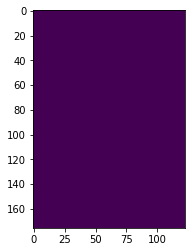

In [83]:
g = gdal.Open(dst_filename)
gdata = g.ReadAsArray()
print (gdata.shape)

import pylab as plt
%matplotlib inline
plt.imshow(gdata[1])
print(gdata.sum())

In [51]:

    


'''
we want to project and clip t2_file to the file ret
'''
# We now create an in-memory raster, with the appropriate dimensions
drv = gdal.GetDriverByName('MEM')
target_ds = drv.Create('', g.RasterXSize, g.RasterXSize, 1,  gdal.GDT_Byte)
target_ds.SetGeoTransform( g.GetGeoTransform() )
# We set up a transform object as we saw in the previous notebook.
# This goes from WGS84 to the projection in the reference datasets

wgs84 = osr.SpatialReference( ) # Define a SpatialReference object
wgs84.ImportFromEPSG( 4326 ) # And set it to WGS84 using the EPSG code

# Now for the target projection, Ordnance Survey's British National Grid
to_proj = osr.SpatialReference() # define the SpatialReference object
# In this case, we get the projection from a Proj4 string

# or, if using the proj4 representation
to_proj.ImportFromWkt( g.GetProjectionRef() )
target_ds.SetProjection ( to_proj.ExportToWkt() )   

target_ds.GetProjection()

'PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'

In [ ]:
t2_file = 'data/europe_data_2016_2017.nc'

# sort the prj 
g = gdal.Warp('',
            [t2_file],
            format='MEM',
            dstNodata=255,
            cutlineDSName=shpfile,
            cutlineWhere=f"FIPS='{country_code:s}'",
            cropToCutline=True)
print(g)

if(g):
    t2 = g.ReadAsArray()

print (t2.shape)

In [ ]:
g = gdal.Open(t2_file)
meta = dict(g.GetMetadata())
print (meta.keys())
t2_time = np.array(meta['NETCDF_DIM_time_VALUES'][1:-1].split(',')).astype(float)
t2_data = g.ReadAsArray()* float(meta['t2m#scale_factor']) + float(meta['t2m#add_offset']) -273.15
print (meta['time#units'])

from datetime import datetime, timedelta
t2_date = np.array([datetime(1900,1,1) + timedelta(days=(t)/24.) for t in t2_time])
print(t2_date[0],t2_date[-1])
plt.figure(figsize=(10,3))
plt.plot(t2_date,t2_data.mean(axis=(1,2)))

In [ ]:
print(t2.shape)
import matplotlib.pylab as plt
%matplotlib inline

plt.imshow(t2[100])

# Model calibration

As an addition  to the notes on function fitting, we consider the ideas of function fitting and model calibration in a bit more detail.

We start with the example of a 'phenology' model as in the previous exercise:


![](http://www2.geog.ucl.ac.uk/~plewis/geogg124/_images/zhang1.png)

We consider a signal (e.g. NDVI) observational data.





In [ ]:
'''
    which tile and year?
'''
tiles = []
for h in [17, 18]:
    for v in [3, 4]:
        tiles.append(f"h{h:02d}v{v:02d}")

year = 2017

dates, lai_array, weights_array = process_timeseries(
    year,
    tiles,
    folder="data/",
    shpfile="data/TM_WORLD_BORDERS-0.3.shp",
    country_code="NL")

In [ ]:
import glob
year = 2005
tile = "h17v03"
# test it
# Search for all the files using wildcards
filelist = glob.glob ("data/MCD15A2.A{}*{}*.hdf".format(year, tile))
filelist.sort()
lai = read_lai(filelist,country='Ireland')
data = np.array(lai['Lai_1km'])
sd = np.array(lai['LaiStdDev_1km'])

# fix uncertainties
thresh = 0.25
sd[sd<thresh] = thresh

and consider a logistic function that we would like to use as a model of LAI development (phenology).

A (double) logistic function is:

$$
 \hat{y} = p_0 - p_1 \left( \frac{1}{1 + e^{p_2 (t - p_3)}} + \frac{1}{1 + e^{p_4 (t - p_5)}} -1\right)
$$

In [ ]:
def dbl_logistic_model ( p, t ):
        """
            A double logistic model, as in Sobrino and Juliean, 
            or Zhang et al
            
            Parameters:, and rough guess
              
            p[0]=  ymean - 1.151*ysd  # minimum  (1.151 is 75% CI)
            p[1] = 2*1.151*ysd        # range
            p[2] = 0.19               # related to up slope
            p[3] = 120                # midpoint of up slope
            p[4] = 0.13               # related to down slope
            p[5] = 220                # midpoint of down slope
        """
        return p[0] - p[1]* ( 1./(1+np.exp(p[2]*(t-p[3]))) + \
                              1./(1+np.exp(-p[4]*(t-p[5])))  - 1 )

In [ ]:
# test pixel
r = 442
c = 84

'''
    set up x and y data for a pixel
'''

y = data[:,r,c]
mask = np.logical_not(np.isnan(y))
y = np.array(y[mask])
x = (np.arange(46)*8+1.)[mask]
unc = np.array(sd[:,r,c][mask])
x_full = np.arange(1,366) 

# some stats on y for rough guesses
ysd = np.std(y)
ymean = np.mean(y)

# some rough guesses at the parameters
p = np.array([ymean - 1.151*ysd,2*1.151*ysd,0.1,120,0.1,240])

'''

Run the logistic model with these parameters

'''
y_hat = dbl_logistic_model(p,x_full)

plt.clf()
plt.plot(x_full,y_hat)
plt.plot(x,y,'*')
plt.errorbar(x,y,unc*1.96)

We can now calculate the residuals. We weight the residuals by the uncertainty, to normalise and express them in 'standard deviation' units.

In [ ]:
def mismatch_function(p, x, y, unc):
    '''
    
    return the residuals 
    weighted by uncertainty
    
    '''
    y_hat = dbl_logistic_model(p, x)
    diff = (y_hat - y)/unc
    return diff

Z = mismatch_function(p,x,y,unc)

plt.plot([1,365.],[0,0.],'k-')
plt.xlim(0,365)
plt.plot(x,Z,'*')

print 'mean Z^2 =',(Z**2).mean()

## Defining and implementing a cost function

More formally, consider the observations (i.e. LAI) as Gaussian distributions $y_{obs}(x)$ ~ $N(\bar{y}(x),C_{obs}(x))$ where $,C_{obs}(x)$ is the variance/covariance matrix (uncertainty) in the LAI observations at time $x$ and $\bar{y}$ its mean.

We assume zero covariance between the errors at each observation, so $C_{obs}(x)$ is a diagonal matrix:

$
C_{obs} = 
\left( \begin{array}{ccc}
\sigma^2_0 & 0 & ... & 0 \\
0 & \sigma^2_1 & ... & 0 \\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & ... & \sigma^2_{n-1} \end{array} \right) 
$

over $n$ samples (in $x$) and $\sigma^2_i$ is the variance of the $i^{th}$ sample (i.e. at $x_i$).

We note that calculating the inverse of this matrix is trivial:

$
C_{obs}^{-1} = 
\left( \begin{array}{ccc}
\frac{1}{\sigma^2_0} & 0 & ... & 0 \\
0 & \frac{1}{\sigma^2_1} & ... & 0 \\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & ... & \frac{1}{\sigma^2_{n-1}} \end{array} \right) 
$


Suppose now that we have a *model*:

$
\hat{y} = f(x,p)
$

where $p$ is a set of parameters of the function.

We wish to obtain an *optimal* estimate of $p$, conditioned on the observations. 

We can do this by considering a *cost function*, $J_{obs}(y_{obs},p)$:

$
J_{obs}(y_{obs},p) = \frac{1}{2} \left[ y(x) - \hat{y}(x,p) \right]^T C_{obs}^{-1}  \left[ y(x) - \hat{y}(x,p) \right]
$

where $^T$ denotes the transpose operation. 

We could implement a general cost function of this sort as:

In [ ]:
def J_obs(p, x, y, C1,
                      model=dbl_logistic_model):
    '''
    
    return 'cost' J
    
    p    : set (vector) of parameters
    x    : sample locations
    y    : function value at sample locations
    C1   : inverse variance /covariance matrix
        
    '''
    y_hat = model(p, x)
    
    diff = np.matrix(y_hat - y).T
    
    return 0.5 * np.array(diff.T * C1 * diff).flatten()[0]


# calculate the inverse var/covar matrix
# NB use np matrix here
# .I gives the inverse

C1 = np.matrix(np.diag(unc**2)).I

Z = J_obs(p,x,y,C1)

print Z

But since we only want to consider a diagonal uncertainty matrix here, it is simpler and faster to use:

In [ ]:
def J_obs_fast(p, x, y, sd,\
                      model=dbl_logistic_model):
    '''
    
    return 'cost' J
    
    p    : set (vector) of parameters
    x    : sample locations
    y    : function value at sample locations
    sd   : uncertainty standard deviation
        
    '''
    y_hat = model(p, x)
    
    diff = (y_hat - y)/sd
    
    return 0.5 * (diff*diff).sum()


Z = J_obs_fast(p,x,y,unc)

print Z

Or ... we could design a function that could do either:

In [ ]:
def J_obs(p, x, y, sd,\
                      model=dbl_logistic_model):
    '''
    
    return 'cost' J
    
    p    : set (vector) of parameters
    x    : sample locations
    y    : function value at sample locations
    sd   : uncertainty standard deviation
           *or* if not same shape as y, then
           assumed to be C1 (inverse var/covar matrix)
        
    '''
    y_hat = model(p, x)

    if sd.shape == y.shape:
        diff = (y_hat - y)/sd
        J = 0.5 * (diff*diff).sum()
    else:
        diff = np.matrix(y_hat - y).T
        J = 0.5 * np.array(diff.T * C1 * diff).flatten()[0]
    
    return J

C1 = np.matrix(np.diag(unc**2)).I

print J_obs(p,x,y,unc)
print J_obs(p,x,y,C1)


Notice that in this example, we can change the model used for calculating $\hat{y}$ (providing we use the same *interface*):

In [ ]:
# cost using logistic model
print J_obs(p,x,y,unc,model=dbl_logistic_model)

# define another model

def sincos(p,x):
    '''
    
    y_hat = p[0] + p[1] sin(t) + p[2] cos(t)
   
    '''
    # put x in range 0 to 2 pi and call it t
    t = np.pi * 2 * x/365.25
    return p[0]*np.sin(t) + p[1] * np.cos(t)

# calculate the cost for this
p2 = [0.1,0.2,0.2]
print J_obs(p2,x,y,unc,model=sincos)


Note that the 2 models we have chosen here have rather different meanings for the parameters. Indeed, the logistic takes 6 parameters (in `p`) but the `sincos` function, only 3. 

## Solving for optimal estimate

Now, consider how Z varies as we vary `p`:

In [ ]:
# vary the first parameter

pvals = np.mgrid[0.0:1.01:0.01]
mse   = np.zeros_like(pvals)
p_ = p.copy()
print p

for i,p0 in enumerate(pvals):
    p_[0] = p0
    Z = J_obs(p_,x,y,unc,model=dbl_logistic_model)
    mse[i] = (Z**2).mean()
    

In [ ]:
plt.plot(pvals,np.sqrt(mse))
plt.xlabel('p0')
plt.ylabel('rmse')

We can consider this a 'slice' through an 'error surface' or 'cost function'. 

We can define the 'optimal' estimate of the parameter vector `p` as the set of `p` values that gives a *minimum* in the error surface, i.e. one for which:

$
\frac{\partial{J}}{\partial{p}} = 0
$

i.e. the rate of change of the error function is zero (in all dimensions).

The function $J$ in this case is 6 dimensional. It is quite hard to visualise that, but we can easily examine two dimensions.



In [ ]:
# vary the first 2 parameters

pvals = np.mgrid[0.0:2.01:0.01,0.0:3.51:0.01]
mse   = np.zeros_like(pvals[0])
p_ = p.copy()

for i in xrange(pvals.shape[1]):
    for j in xrange(pvals.shape[2]):
        for k in xrange(pvals.shape[0]):
            p_[k] = pvals[k,i,j]
            Z = J_obs(p_,x,y,unc,model=dbl_logistic_model)
            mse[i,j] = (Z**2).mean()
    

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow ( np.sqrt(mse), interpolation='nearest', extent=(0, 3.5, 0, 2.), origin="lower",
           cmap=plt.cm.BuPu_r)
plt.colorbar(orientation="horizontal", shrink=0.7)
cs = plt.contour( pvals[1], pvals[0], np.sqrt(mse), [50, 100, 150, 200, 400, 600])
plt.clabel(cs, fmt = '%2.1f', fontsize=8)

In both the one and two dimensional 'slices' we can quite easily spot the minimum of the error function. Remember that this is *only* for a particular set of values of the parameters that we do not vary here.

## Look up table

One approach to finding the global minimum would be to simply calculate $J$ at some set of points (e.g. on a six dimensional grid), and to see which point showed the minimum of $J$. We can do this here:

In [ ]:
'''
 recall the meaning of the parameters for the model we are using

 p[0]=  ymean - 1.151*ysd  # minimum  (1.151 is 75% CI) of LAI
 p[1] = 2*1.151*ysd        # range of LAI
 p[2] = 0.19               # related to up slope
 p[3] = 120                # midpoint of up slope
 p[4] = 0.13               # related to down slope
 p[5] = 220                # midpoint of down slope

'''

# consider parameter bounds

b = np.array([(0.01,10.),(0.01,10.),(0.01,1.),\
                  (50.,300.),(0.01,1.),(50.,300.)])

# number of samples per dimension (+1)
N = 5

# work out what steps to use over the grid
s = [(bound[1]-bound[0])/float(N) for bound in b]
# form a grid of samples over parameter space

pvals = np.mgrid[b[0,0]:b[0,1]+s[0]:s[0],\
                 b[1,0]:b[1,1]+s[1]:s[1],\
                 b[2,0]:b[2,1]+s[2]:s[2],\
                 b[3,0]:b[3,1]+s[3]:s[3],\
                 b[4,0]:b[4,1]+s[4]:s[4],\
                 b[5,0]:b[5,1]+s[5]:s[5]]

# set sse default to high
sse   = np.zeros_like(pvals[0]) + 1e20
p_ = p.copy()

print 'the grid shape is',pvals.shape
print 'the LUT grid has',pvals.size,'entries'

for i0 in xrange(pvals.shape[1]):
  for i1 in xrange(pvals.shape[2]):
    for i2 in xrange(pvals.shape[3]):
      for i3 in xrange(pvals.shape[4]):
        for i4 in xrange(pvals.shape[5]):
          for i5 in xrange(pvals.shape[6]):

            for k in xrange(pvals.shape[0]):
              p_[k] = pvals[k,i0,i1,i2,i3,i4,i5]
              
              try:
                Z = J_obs(p_,x,y,unc,model=dbl_logistic_model)
                sse[i0,i1,i2,i3,i4,i5] = (Z**2).sum()
              except:
                pass

but this takes a relatively long time, *even* if we use a really coarse grid as in this example (with a few hundred thousand samples).

That said, LUT inversion is a pragmatic response to trying to find an optimal solution for the parameters when fitting a model. It is viable in low dimensional space, but becomes problematic as the number of dimensions increases. 

Note also that, as it stands, it can only provide a rough estimate of the parameters:

In [ ]:
'''

Seek the minimum SSE

'''
# find the minimum value over the grid
minSSE = np.min(sse)
print 'the minimum value is',minSSE

# find where that occurs
w = np.where(sse == minSSE )
print '\nthe min is at sample',w

# a bit awkward to pull this out but it is possible
result = np.array(pvals[:,w[0],w[1],w[2],w[3],w[4],w[5]]).T[0]

print '\nthe result is',result 

In [ ]:
# actually, we would typically use np.argmin
# for this

minsamp = np.argmin(np.array(sse))

# now extract that for each parameter
result = np.array([pvals[i].flatten()[minsamp] \
                   for i in xrange(pvals.shape[0])])

print '\nthe result is',result 

# so we see we get the same result, whichever approach we take

If we now plot the data and model with these parameters:

In [ ]:
y_hat = dbl_logistic_model(result,x_full)

plt.plot(x_full,y_hat)
plt.plot(x,y,'*')
plt.errorbar(x,y,unc*1.96)

we can see that it is not a bad effort (in that it broadly describes the data), but we do not know whether a 'better' (lower J) solution could have been obtained in between the grid points.

### A faster LUT

In the code snippet above, when creating the LUT, we can see that we have many nested loops. Generally speaking, this is a bad idea. We have also seen that the code is very slow. We can try to do the same here using some tricks to speed things up. In Python (as well as R, and to some extent, matlab and others), speed is usually hampered by having lots of ntested loops. We can usually do away with them. 

One way of creating a LUT efficiently is to note that if we have the same sample points along each dimension, the LUT is just the *cartesian product* of the (in this case 6) different dimensions. Here's the cartesian product for two dimensions:
<p><a href="https://commons.wikimedia.org/wiki/File:Cartesian_Product_qtl1.svg#/media/File:Cartesian_Product_qtl1.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/4/4e/Cartesian_Product_qtl1.svg" alt="Cartesian Product qtl1.svg" height="145" width="191"></a><br>By <a href="//commons.wikimedia.org/wiki/User:Quartl" title="User:Quartl">Quartl</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="http://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=22436861">Link</a></p>

The Python [itertools](http://jmduke.com/posts/a-gentle-introduction-to-itertools/) module has this functionality implemented in the [`product`](https://docs.python.org/2/library/itertools.html#itertools.product) method. So we just need to create one list or array per dimension with the sampling points, and then use `itertools.product` to create our LUT.

We can then use the python `map` method, which applies each element in an iterator (e.g. each row of the LUT) to a function. The function can only take  one parameter, so we have to *alias* `J_obs` using a `lambda` function that fixes the additional parameters in the function call. The result of this is an array with the cost associated with each parameter set in the LUT.

We can use the `argmin` method to find the location of the minimum, and then use that position in the LUT array to get the parameters that get the best result.

In [ ]:

# The parameter boundaries
b = np.array([(0.01,10.),(0.01,10.),(0.01,1.),
                  (50.,300.),(0.01,1.),(50.,300.)])
print b.shape
import itertools

n_samples =10 # 5 samples by dimension
pre_lut = np.zeros((6,n_samples)) # For each dimension, we store one vector with n_samples
for i in xrange(6):
    pre_lut[i,:] = np.linspace ( b[i,0], b[i,1], n_samples)
    
# Generates the LUT by doing a cartesian product of the 6 dimensions
LUT = [xx for xx in itertools.product ( pre_lut[0], pre_lut[1], 
                                       pre_lut[2], pre_lut[3], pre_lut[4], pre_lut[5])]
LUT = np.array(LUT) # Convert to array
print LUT.shape

# Calculate the cost function

cost_f = lambda pp: J_obs(pp,x,y,unc,model=dbl_logistic_model)**2 
cost = map (cost_f, LUT)
cost = np.array (cost)
iloc = cost.argmin()
print cost[iloc]
print LUT[iloc, :]
y_hat = dbl_logistic_model(LUT[iloc,:],x_full)

plt.plot(x_full,y_hat)
plt.plot(x,y,'*')
plt.errorbar(x,y,unc*1.96)

One interesting observation is that most of the time is spend evaluating the cost function (the creating of the LUT is quite fast), and that most modern computers have several CPUs. The calculation of the cost function for each element of the LUT is completely independent (the calculation of element 1 and element 100 is completely independent). We could evaluate these functions *in parallel*. To do that, we can use the [`multiprocessing`](https://pymotw.com/2/multiprocessing/basics.html) module. Once we import the `Pool` and define it (it's basically a pool of "*workers*" with the size of cores in your computer), then a map method will spread the calculations over the workers. As before, we write a wrapper function to ignore the extra nuisance parameters in `J_obs`, but in this case using a real function.

In [ ]:
from multiprocessing import Pool

def cost_f2 (pp):
    return J_obs(pp,x,y,unc,model=dbl_logistic_model)**2 


pool = Pool()
print "Multicore:"
%time costf = np.array(pool.map(cost_f2, LUT))

print "Singlecore"
%time cost = np.array(map (cost_f, LUT))

print np.allclose (cost, costf)



On my laptop, this provides a speedup of around 3x.

<div style="padding: 20px;
    background-color: #f44336;
    color: white;
    font-size: 130%">
Warning! If you use multiprocessing, you will use all of the computer resources. Be gentle with other users, and use <tt>nice -19 jupyter notebook</tt> when launching the notebook (see <a href="https://www.cyberciti.biz/faq/change-the-nice-value-of-a-process/">here</a> for more information).
</div>


## Exercise

Although we have not used the fact in the example above, the real benefit of a LUT is that you can *pre-calculate* the results at each of the grid points. This means that if you had a computationally expensive model, you could calculate $\hat{y}(x)$ for all grid points (note that this would be quite a large dataset). 

Implement a LUT optimisation approach (with a smaller grid than that used above). To do this:

1. calculate the grid points, similarly to above (but perhaps a bit smaller)
2. calculate and store $\hat{y}(x)$ for each grid point.
3. Calculate the cost $J$ between a particular observation (i.e. the values of LAI for a given pixel) and the LUT values (normalise dby uncertainty)
4. Find the minimum over the LUT and the associated parameter values

You should then plot your results as above. 

Since we have to calculate $\hat{y}(x)$ at all grid points, generating the LUT might take a few minutes. 

What then is the advantage of this approach?

## Using a minimisation routine

Although there are sometimes great practical advantages to using a LUT, there can be distinct downsides too (e.g. quantisation).

Another approach is that we use some 'algorithm' that seeks the N-dimensional minimum by 'moving' around the parameter space.

One such approach, and generally a useful algorithm is [L-BFGS-B](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fmin_l_bfgs_b.html).

In [ ]:
from scipy import optimize

p = result

# initial estimate is in p
print 'initial parameters:',p[0],p[1],p[2],p[3],p[4],p[5]

# set some bounds for the parameters
bound = np.array([(0.01,10.),(0.01,10.),(0.01,1.),\
                  (50.,300.),(0.01,1.),(50.,300.)])



def sse(p,x,y,unc):
    '''Sum of squared error'''
    # penalise p[3] > p[5]
    err = np.max([0.,(p[3] - p[5])])*1e4
    return J_obs(p,x,y,unc,model=dbl_logistic_model)+err

# we pass the function:
#
# sse               : the name of the function we wrote to give 
#                     sum of squares of Z_i
# p                 : an initial estimate of the parameters
# args=(x,y,unc)    : the other information (other than p) that
#                     mismatch_function needs
# approx_grad       : if we dont have a function for the gradien
#                     we have to get the solver to approximate it
#                     which takes time ... see if you can work out
#                     d_sse / dp and use that to speed this up!

psolve = optimize.fmin_l_bfgs_b(sse,p,approx_grad=True,iprint=1,\
                                args=(x,y,unc),bounds=bound)

print psolve[1]
pp = psolve[0]
plt.plot(x,y,'*')
plt.errorbar(x,y,unc*1.96)
y_hat = dbl_logistic_model(pp,x_full)
plt.plot(x_full,y_hat)

print 'solved parameters: ',pp[0],pp[1],pp[2],pp[3],pp[4],pp[5]

print '\nJ(min) = ',J_obs(p,x,y,unc,model=dbl_logistic_model)

# if we define the phenology as the parameter p[3]
# and the 'length' of the growing season:
print '\nphenology',pp[3],pp[5]-pp[3]

which gives a much more plausible result and a *much* lower SSE and took around 100 iterations (so a few hundred calculations of the cost function). 



## Exercise

Consider what the advantages and disadvantages of this sort of approach might be (e.g. compared to the LUT) (e.g. depending on whther there are *many* models to fit or only a few).

The uncertainty in the parameters can be obtained from the Hessian of the cost function. See if you can work out how that might be calculated.